In [1]:
import os
import json
import cv2
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from pose_data import PoseGraph
#from torch_geometric.data import Data
#from torch.utils.data import Dataset, DataLoader

In [2]:
pg = PoseGraph()

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


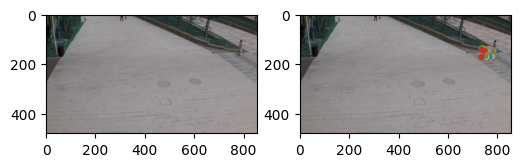

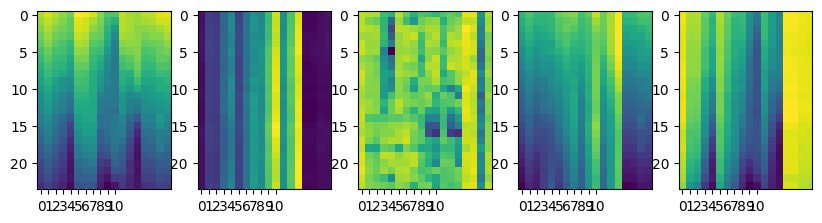

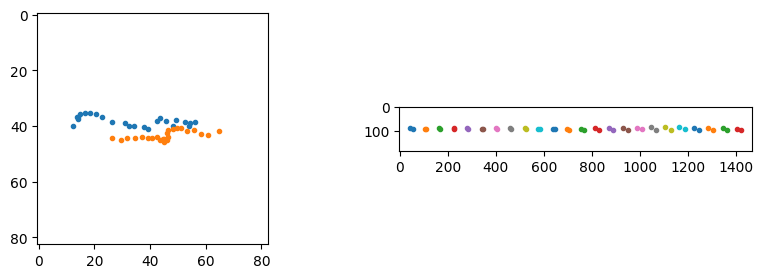

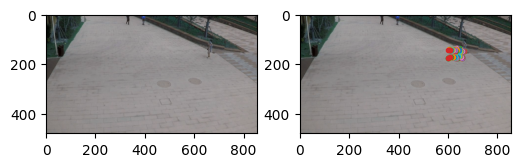

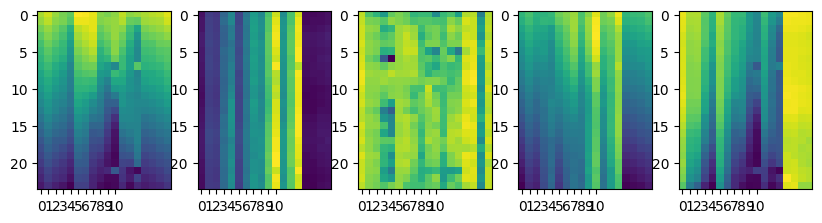

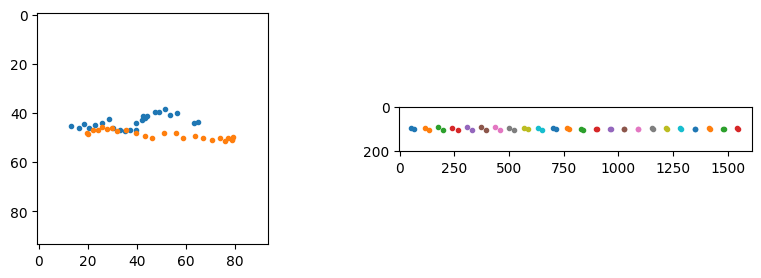

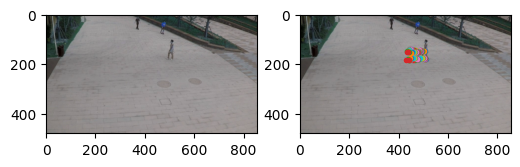

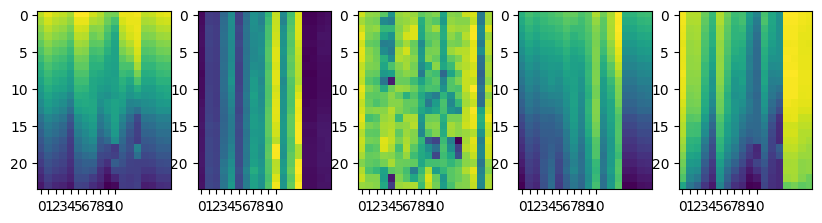

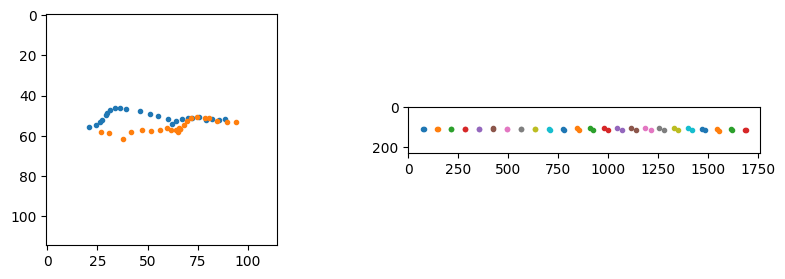

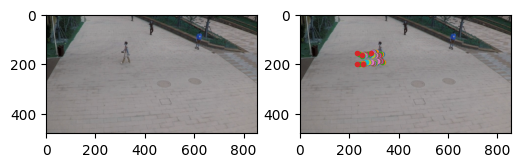

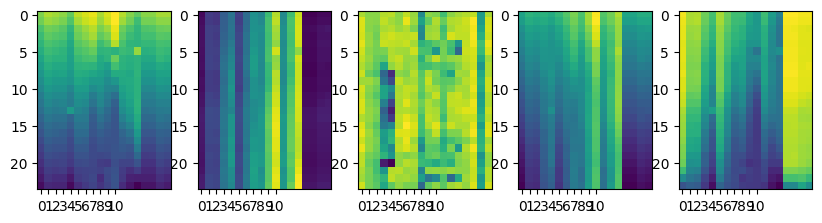

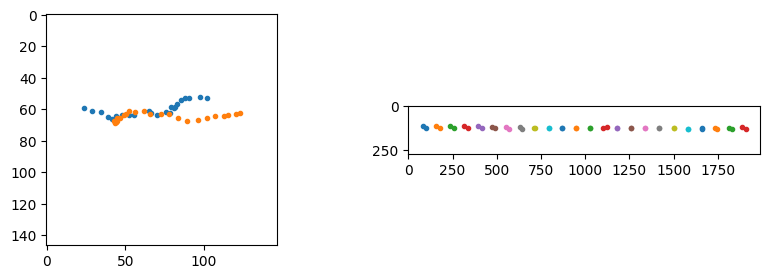

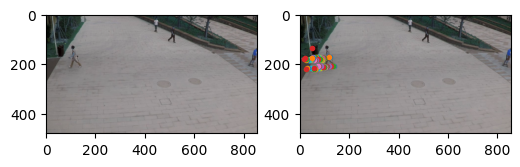

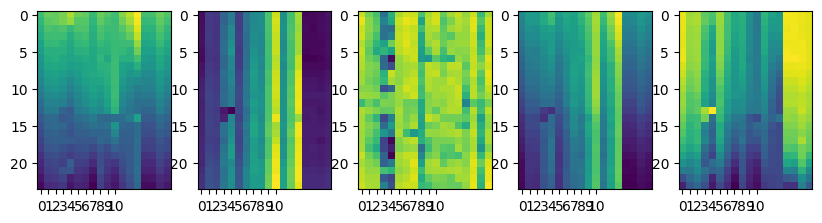

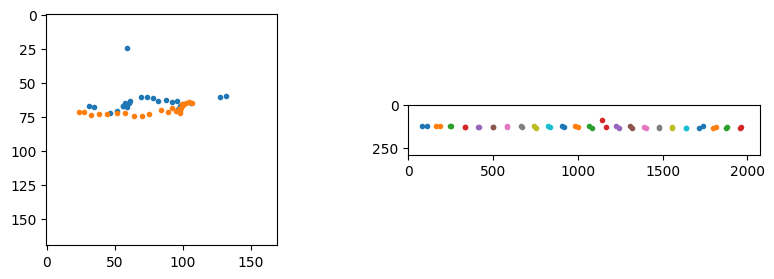

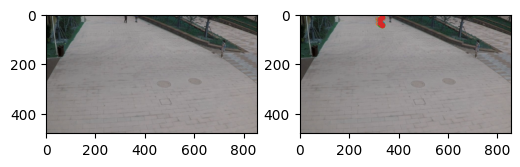

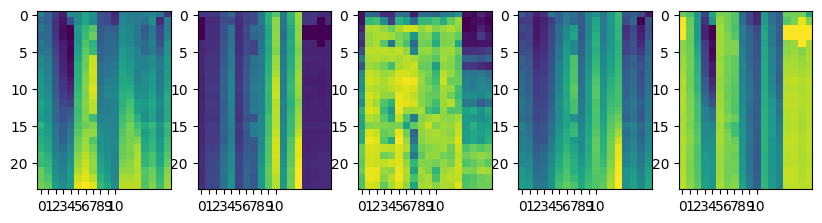

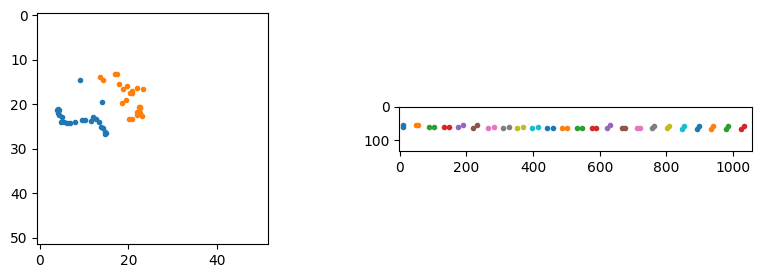

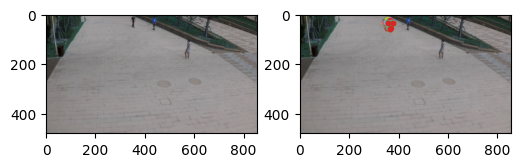

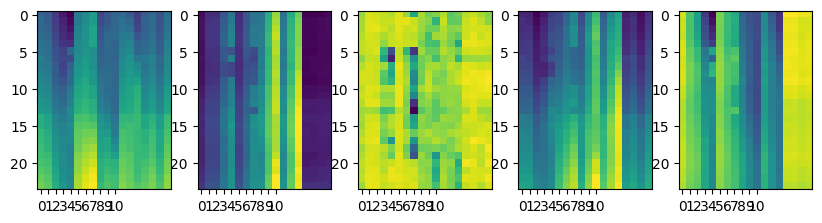

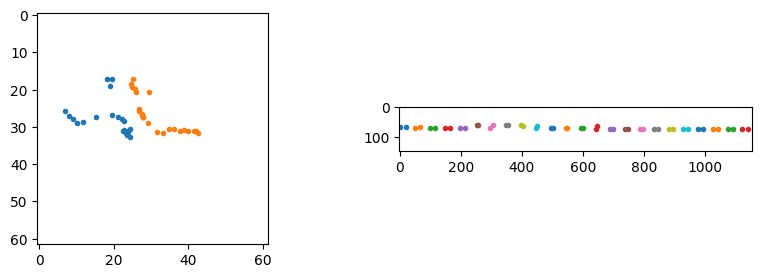

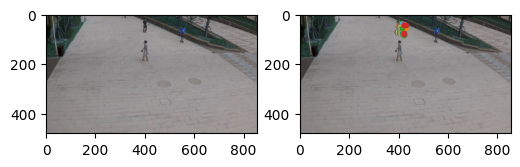

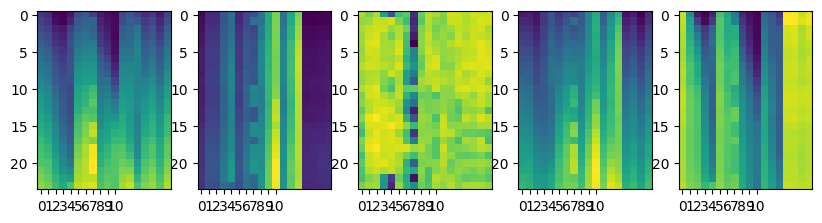

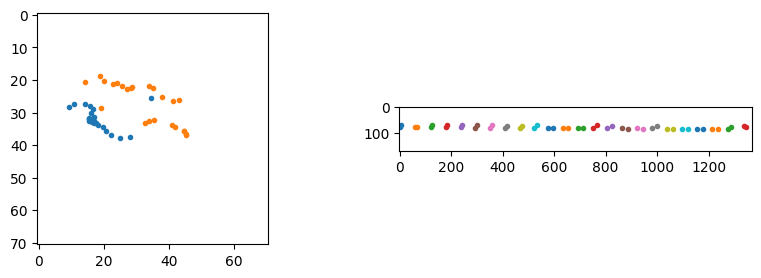

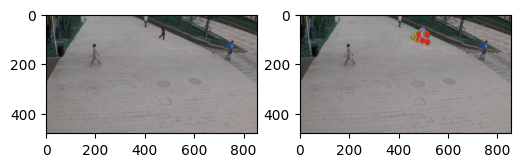

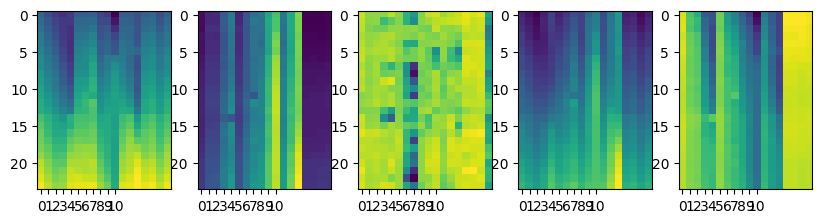

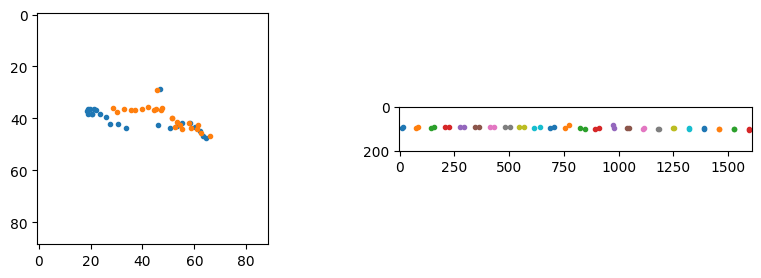

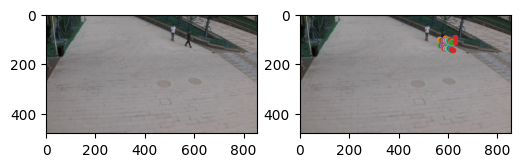

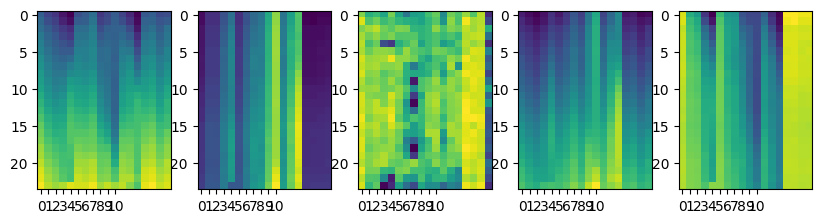

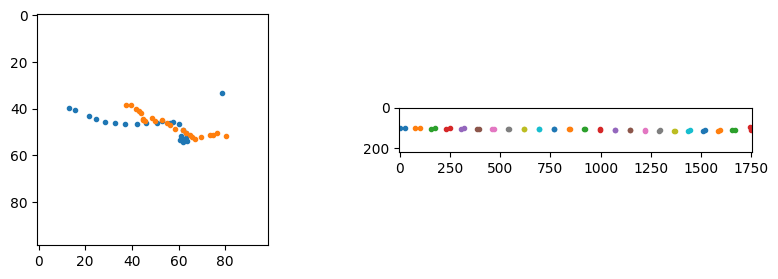

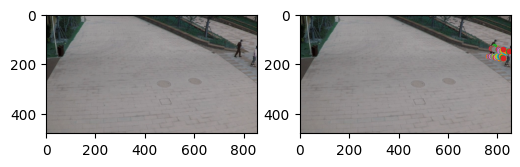

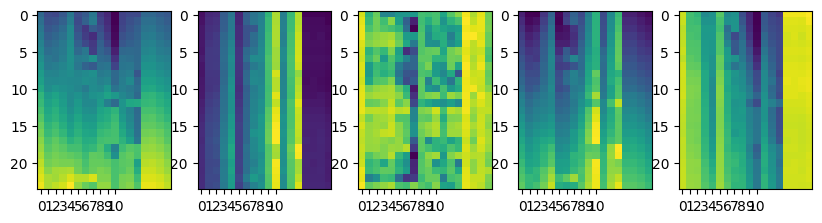

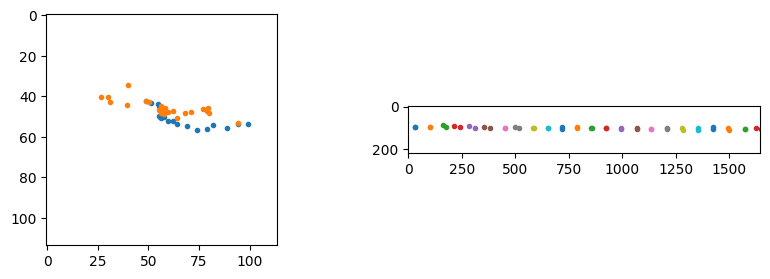

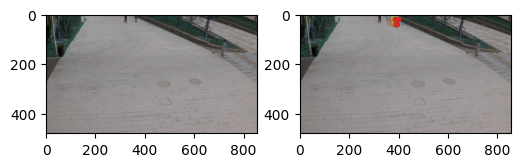

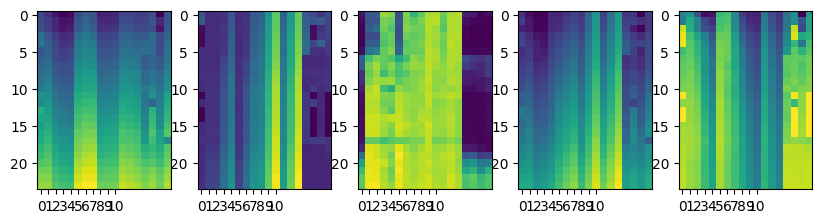

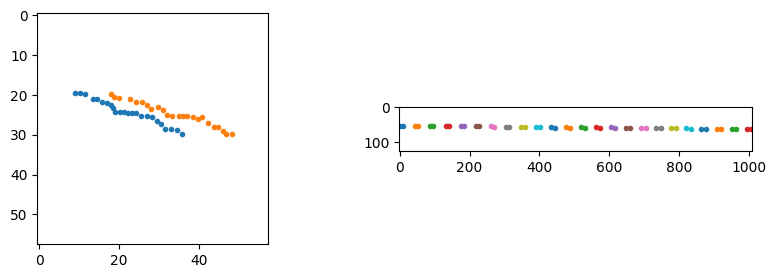

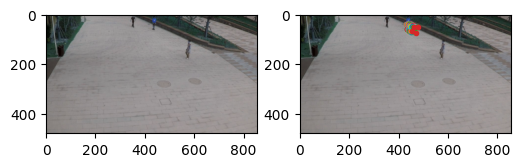

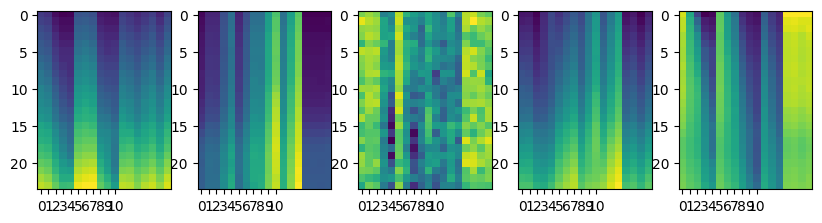

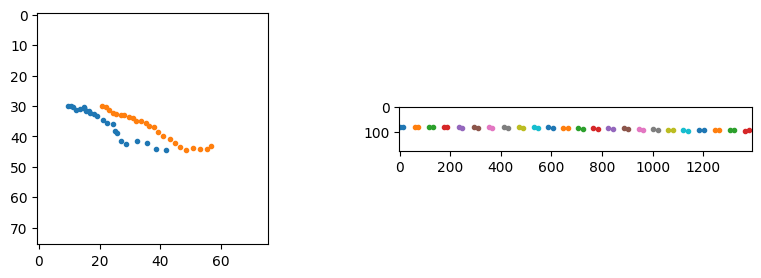

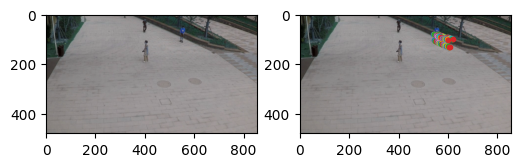

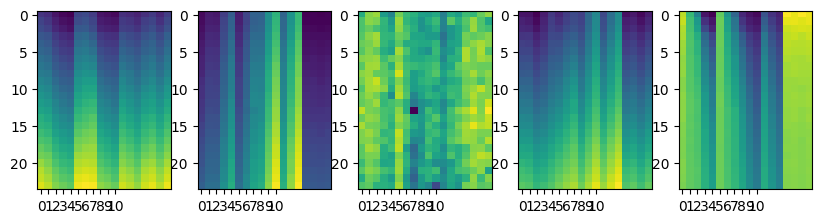

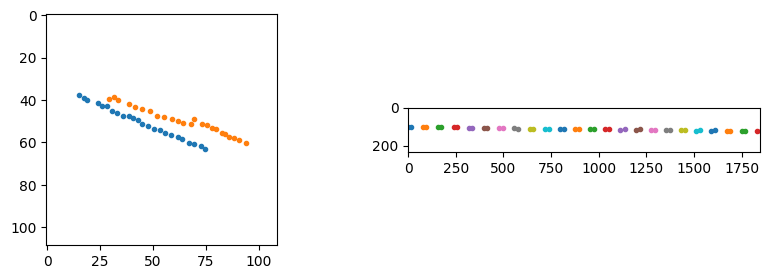

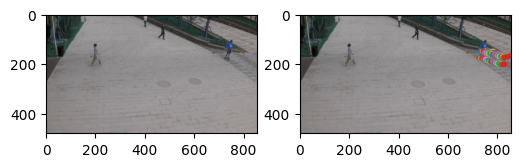

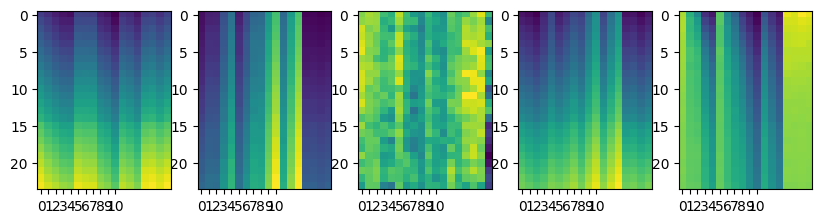

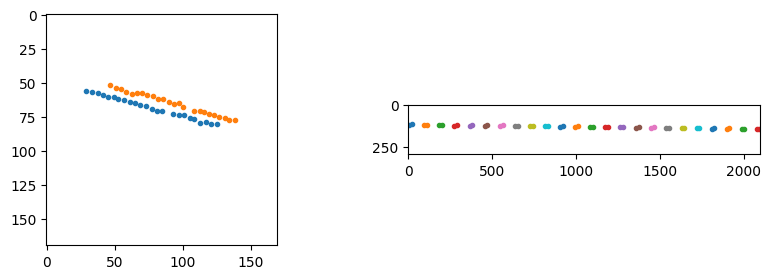

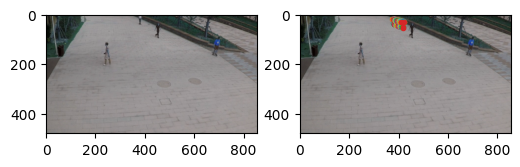

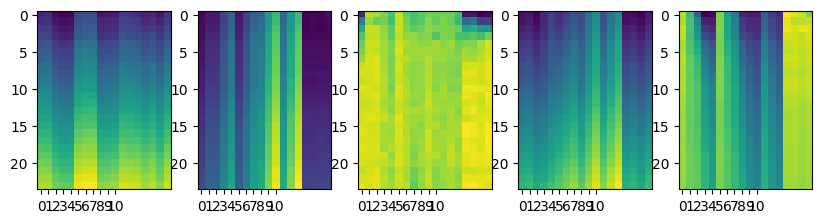

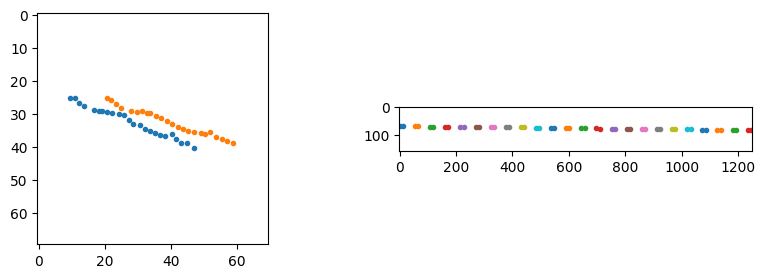

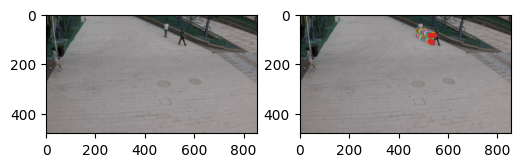

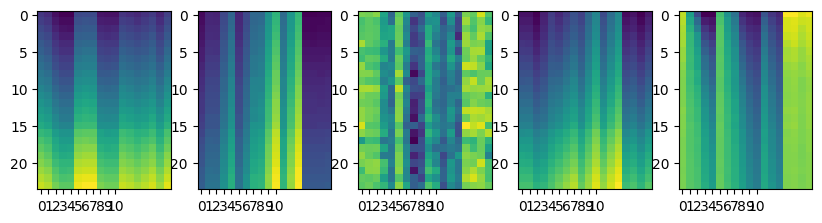

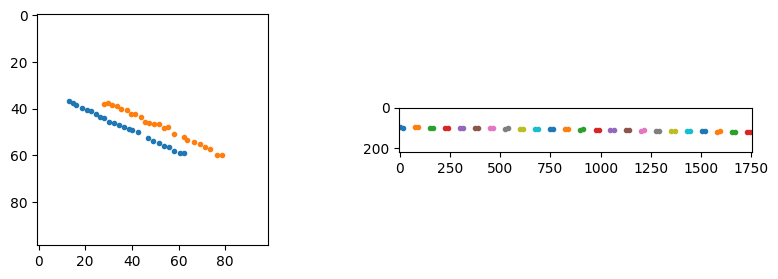

In [3]:
for i in range(400,900,30):
    pg.plot_pose(i,_id=[4,7,10,13])
    pg.plot_hmap(i)
    pg.vis_data(i,_id=[4,7])

In [4]:
dt,mtd = pg.__getitem__(500)

In [5]:
from gpec_models.gcae.gcae import Encoder
from gpec_models.fe.fe_model import init_fenet
model = init_fenet(None)

In [7]:
import torch
_dt   = torch.tensor(dt.transpose(2,0,1)[None],dtype=torch.float32).to('cuda:0')
model.train()
model = model.to('cuda:0')
out   = model(_dt)

In [16]:
out[0][0].shape

torch.Size([3, 24, 18])

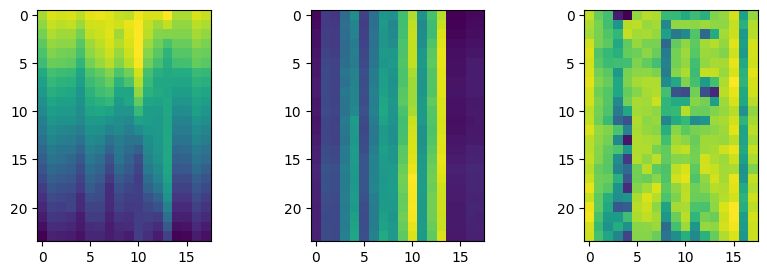

In [18]:
_t = dt
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
axes[0].imshow(_t[:,:,0])
axes[1].imshow(_t[:,:,1])
axes[2].imshow(_t[:,:,2])

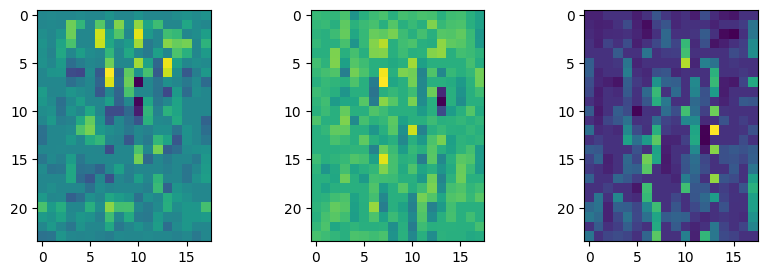

In [17]:
_t = out[0][0].detach().cpu().numpy().transpose(1,2,0)
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
axes[0].imshow(_t[:,:,0])
axes[1].imshow(_t[:,:,1])
axes[2].imshow(_t[:,:,2])

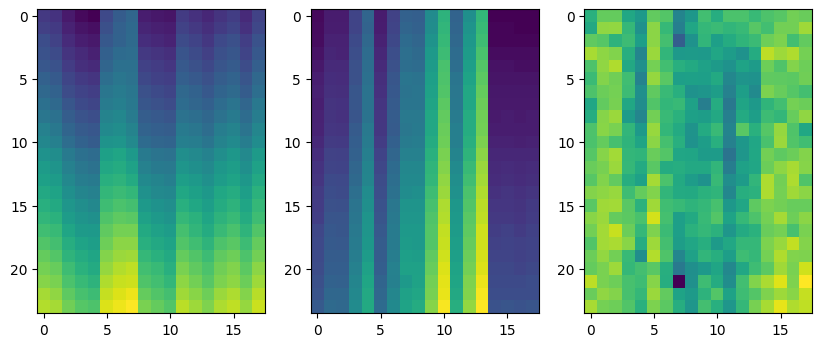

In [147]:
dt,mtd = pg.__getitem__(786)
#_dt    = dt.transpose(1,2,0)
dt[:,:,0]-=dt[:,:,0].min()
dt[:,:,1]-=dt[:,:,1].min()
dt[:,:,0]/=dt[:,:,0].max()
dt[:,:,1]/=dt[:,:,1].max()
dt[:,:,2]/=dt[:,:,2].max()
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
axes[0].imshow(dt[:,:,0])
axes[1].imshow(dt[:,:,1])
axes[2].imshow(dt[:,:,2])

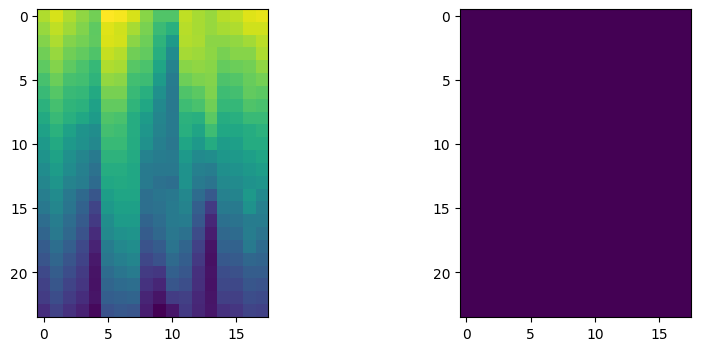

In [138]:
dt,mtd = pg.__getitem__(400)
#_dt    = dt.transpose(1,2,0)
dt[:,:,0]-=dt[:,:,0].min()
dt[:,:,1]-=dt[:,:,1].min()
dt[:,:,0]/=dt[:,:,0].max()
dt[:,:,1]/=dt[:,:,1].max()
dt[:,:,2]=0
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axes[0].imshow(dt[:,:,0])
axes[1].imshow(dt[:,:,2])

In [140]:
dt[:,:,2].max()

0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


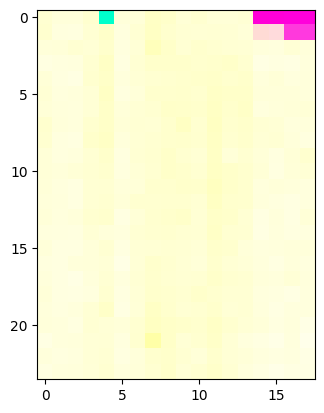

In [109]:
dt.min()

0.0

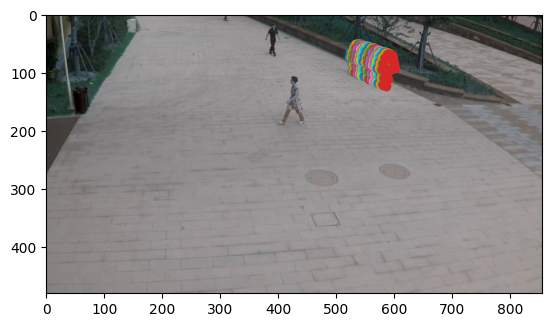

In [98]:
plot_pose(dt,mtd)

In [50]:
size  = dt.max().astype('int32')
frame = np.zeros((size,size,3),dtype=np.uint8)

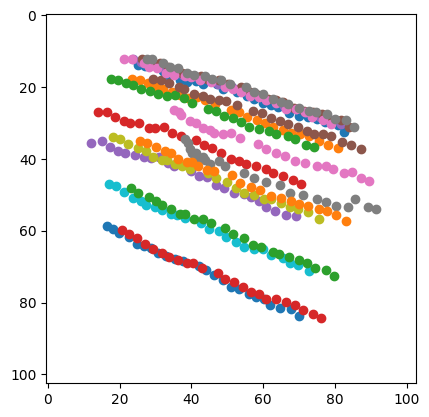

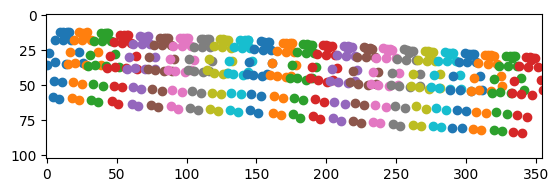

In [18]:
vis_data(_dt)

In [134]:
__dt[:,:,1].max()

59.728516

In [ ]:
import argparse
import os.path as osp
import time
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GAE, VGAE, GCNConv

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--variational', action='store_true')
parser.add_argument('--linear', action='store_true')
parser.add_argument('--dataset', type=str, default='Cora',
                    choices=['Cora', 'CiteSeer', 'PubMed'])
parser.add_argument('--epochs', type=int, default=400)
args = parser.parse_args()

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
path = osp.join(osp.dirname(osp.realpath('.')), '..', 'data', 'Planetoid')
dataset = Planetoid(path, args.dataset, transform=transform)
train_data, val_data, test_data = dataset[0]


class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class LinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)


class VariationalLinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_mu = GCNConv(in_channels, out_channels)
        self.conv_logstd = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


in_channels, out_channels = dataset.num_features, 16

if not args.variational and not args.linear:
    model = GAE(GCNEncoder(in_channels, out_channels))
elif not args.variational and args.linear:
    model = GAE(LinearEncoder(in_channels, out_channels))
elif args.variational and not args.linear:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
elif args.variational and args.linear:
    model = VGAE(VariationalLinearEncoder(in_channels, out_channels))

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    if args.variational:
        loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
for epoch in range(1, args.epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")